Autor: Esteban Suárez Calvo

In [1]:
import numpy as np
from keras import Model, Sequential, initializers, layers, regularizers
from keras.callbacks import EarlyStopping
from keras.datasets import fashion_mnist
from keras.src.callbacks.history import History
from keras.utils import to_categorical
from sklearn.metrics import classification_report

from plot_utils import multiplot

2025-11-19 20:46:05.017623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CCAM - Práctica 1: Redes Neuronales Clásicas

## 1. Preprocesado

### Cargar el dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print("Train images shape: " + str(train_images.shape))
print("Test images shape: " + str(train_images.shape))

Train images shape: (60000, 28, 28)
Test images shape: (60000, 28, 28)


### *Aplanar* las imágenes

*Aplanamos* las imágenes, de manera que pasen a estar representadas por un array de una única dimensión en lugar de un array de 2 dimensiones. De esta manera, cada elemento de este array se corresponderá con una neurona de la capa de entrada.

In [3]:
train_images = train_images.reshape(60_000, 28 * 28)
test_images = test_images.reshape(10_000, 28 * 28)

### Normalización de los datos de entrada

Normalizamos los datos para que estén en un intervalo $[0, 1]$.

In [4]:
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

### *One-hot encoding*

Codificamos las etiquetas con *one-hot encoding*, de manera que cada etiqueta esté conformada por un array de $n$ números, (siendo $n$ el número de elementos que queremos etiquetar, en este caso 10), donde únicamente uno de los elementos del array vale 1 (los demás 0).

In [5]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## 2. Desarrollar una red neuronal clásica

### Crear la red neuronal

Tras haber probado diferentes configuraciones, seleccionamos un modelo de 2 capas ocultas:

1. Una primera capa de 128 neuronas.
2. Una segunda capa de 64 neuronas.

Al utilizar una única capa obtenemos un *accuracy* menor, y al añadir más capas no mejora.

En cuanto a las funciones de activación, utilizamos `relu` para las capas ocultas y `softmax` para la salida.

In [6]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

2025-11-19 20:46:09.454778: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

Creamos una función `fit` para entrenar al modelo (esto no es estrictamente necesario, pero dado que reutilizaremos este trozo de código a lo largo de todo el notebook, tiene sentido hacerlo para no repetir el mismo trozo de código un montón de veces).

Esta función define una serie de valores por defecto para los siguientes hiperparámetros:

- `epochs = 50`: es un número bastante elevado, pero dado que introducimos un *callback* `EarlyStopping` con `patience=6`, rara vez se realizan todas estas iteraciones. La idea es mantenerlo alto, ya que para este problema en concreto y con la red neuronal utilizada, es muy poco costosa cada una de las iteraciones, por lo que podemos permitirnos un número de epochs elevados.

- `batch_size = 128`

- `validation_split = 0.05`: dividimos el conjunto de entrenamiento en entrenamiento (95% de los datos) y validación (5% restante). Dado que el conjunto de entrenamiento es muy grande (60000 elementos), no hace falta que el conjunto de validación tenga un porcentaje excesivamente elevado, ya que con un 5% tendremos suficientes datos (3000 elementos). Es importante resaltar que cuantos más datos dediquemos al entrenamiento, mejor será el modelo resultante.

Destacar que al activar la funcionalidad `restore_best_weights` en el callback de `EarlyStopping`, el modelo resultante del entrenamiento será el mejor de todos los que hemos obtenido en las diferentes iteraciones (en este caso, el que  minimice el `val_loss`).

In [7]:
def fit(
    model: Model,
    epochs: int = 50,
    patience: int = 6,
    batch_size=128,
    validation_split=0.05,
) -> History:
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping],
    )

Una vez tenemos esta función definida, podemos pasar a entrenar el modelo.

Modificamos `epochs=30` y `patience=30` para asegurarnos de que se ejecutan 30 iteraciones. Esto no tiene mucho sentido hacerlo ya que patience no hará nada, pero en este primer entrenamiento es lo que buscamos, ya que así podemos visualizar claramente el sobreentrenamiento.

In [8]:
history = fit(model, epochs=30, patience=30)

Epoch 1/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8088 - loss: 0.5478 - val_accuracy: 0.8450 - val_loss: 0.4255
Epoch 2/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8618 - loss: 0.3879 - val_accuracy: 0.8673 - val_loss: 0.3735
Epoch 3/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8735 - loss: 0.3503 - val_accuracy: 0.8607 - val_loss: 0.3747
Epoch 4/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8820 - loss: 0.3257 - val_accuracy: 0.8800 - val_loss: 0.3303
Epoch 5/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8882 - loss: 0.3074 - val_accuracy: 0.8800 - val_loss: 0.3324
Epoch 6/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8929 - loss: 0.2933 - val_accuracy: 0.8800 - val_loss: 0.3208
Epoch 7/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8976 - loss: 0.2774 - val_accuracy: 0.8850 - val_loss: 0.3166
Epoch 8/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9005 - loss: 0.2678 - val_accuracy: 0.

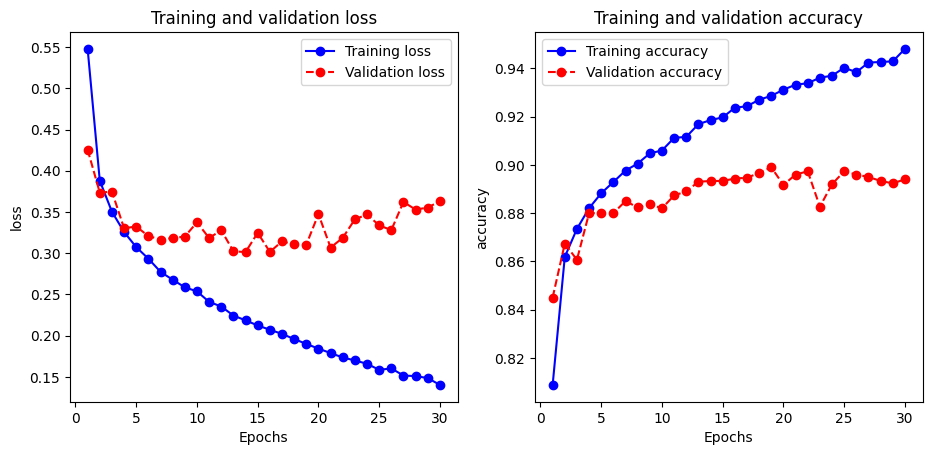

In [9]:
multiplot(history)

Como podemos observar en la gráfica de *loss*, en torno a la décima iteración llegamos a un mínimo en el conjunto de validación. A partir de ese punto, el modelo sigue mejorando para el conjunto de entrenamiento, pero esa mejora no se traduce en una mejora en el conjunto de validación.

Esto es síntoma de que el modelo sigue aprendiendo, pero a base de memorizar los casos de entrenamiento, no a base de mejorar su capacidad de inferencia (clasificar casos que nunca ha visto de manera correcta), que es lo que realmente nos  importa.

### Evaluación del modelo

Definimos la siguiente función para imprimir una tabla con los resultados de la evaluación sobre el conjunto de test:

In [10]:
def evaluate(model: Model) -> None:
    global test_images, test_labels
    true_classes = np.argmax(test_labels, axis=1)

    predicted_values = model.predict(test_images)
    predicted_classes = np.argmax(predicted_values, axis=1)

    report = classification_report(
        true_classes,
        predicted_classes,
        target_names=[
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ],
    )

    print("Classification report:")
    print(report)

Lo evaluamos

In [11]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.87      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.82      0.81      0.81      1000
       Dress       0.88      0.92      0.90      1000
        Coat       0.81      0.82      0.82      1000
      Sandal       0.99      0.94      0.96      1000
       Shirt       0.75      0.67      0.71      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 3. Regularización

A continuación, modificaremos nuestra red neuronal aplicando diferentes tipos de técnicas de regularización para evitar el sobreajuste, con el fin de obtener así mejores clasificadores.

Veamos ahora diferentes técnicas aplicadas de manera individual. Posteriormente las combinaremos para obtener así una mejor red neuronal para nuestro problema.

#### *Dropout*

El dropout desconecta aleatoriamente un cierto porcentaje de neuronas durante el entrenamiento, lo que obliga a la red a no depender de patrones locales, reduciendo así el sobreajuste.

En este caso, dropout desconecta el 50% de las neuronas.

In [12]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

history = fit(model)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6760 - loss: 0.9196 - val_accuracy: 0.8250 - val_loss: 0.4871
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7909 - loss: 0.5964 - val_accuracy: 0.8460 - val_loss: 0.4284
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8149 - loss: 0.5368 - val_accuracy: 0.8567 - val_loss: 0.3954
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8246 - loss: 0.5031 - val_accuracy: 0.8590 - val_loss: 0.3879
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8306 - loss: 0.4831 - val_accuracy: 0.8653 - val_loss: 0.3826
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8362 - loss: 0.4709 - val_accuracy: 0.8680 - val_loss: 0.3785
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8396 - loss: 0.4586 - val_accuracy: 0.8600 - val_loss: 0.3750
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8441 - loss: 0.4477 - val_accuracy: 0.

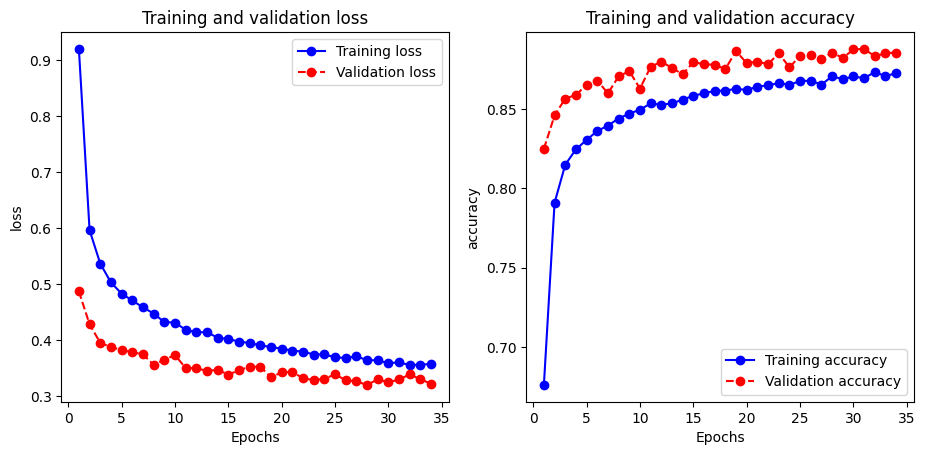

In [13]:
multiplot(history)

In [14]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.86      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.80      0.75      0.78      1000
       Dress       0.86      0.91      0.88      1000
        Coat       0.75      0.83      0.79      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.72      0.60      0.66      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Como podemos observar, tras aplicar un dropout del 50%, la red no se ajusta tanto a los datos de entrenamiento, manteniendo así una mayor concordancia en los resultados de entrenamiento y validación.

Para ambos conjuntos, el accuracy es de en torno al 88%.

#### *Batch normalization*

Esta técnica consiste en normalizar la salida de cada capa con el objetivo de hacer que la red sea más estable.

In [15]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax"),
    ]
)

history = fit(model)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8231 - loss: 0.5042 - val_accuracy: 0.8560 - val_loss: 0.3981
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8704 - loss: 0.3648 - val_accuracy: 0.8677 - val_loss: 0.3453
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8822 - loss: 0.3266 - val_accuracy: 0.8760 - val_loss: 0.3361
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8895 - loss: 0.3016 - val_accuracy: 0.8873 - val_loss: 0.3168
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8963 - loss: 0.2833 - val_accuracy: 0.8853 - val_loss: 0.3101
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9010 - loss: 0.2689 - val_accuracy: 0.8913 - val_loss: 0.3158
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9063 - loss: 0.2551 - val_accuracy: 0.8833 - val_loss: 0.3075
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9104 - loss: 0.2441 - val_accuracy: 0.

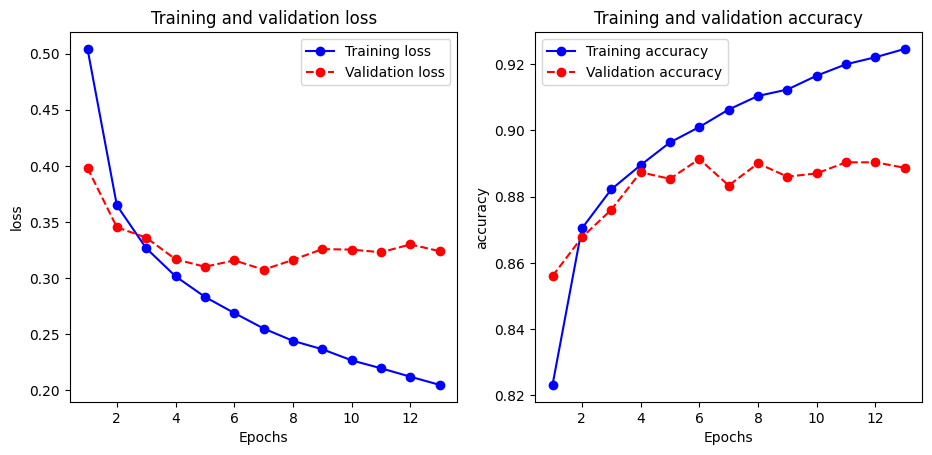

In [16]:
multiplot(history)

In [17]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.82      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.79      0.79      1000
       Dress       0.82      0.91      0.87      1000
        Coat       0.81      0.79      0.80      1000
      Sandal       0.95      0.97      0.96      1000
       Shirt       0.69      0.68      0.68      1000
     Sneaker       0.96      0.92      0.94      1000
         Bag       0.98      0.95      0.97      1000
  Ankle boot       0.93      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Como podemos observar en la gráfica anterior, normalizar el batch después de cada capa oculta sí que ayuda a que el *loss* y el *accuracy* sean más estables, pero **no evita el sobreentrenamiento**.

#### Regularización de pesos

La regularización de pesos consiste en añadir un coste a la función de error asociado con tener valores muy altos en los pesos.

Existen 2 formas de hacer esto, regularización L1 (Lasso) y L2 (Ridge).

- **Regularización L1 (Lasso)**

$$
loss = Error(y, \hat y) + \lambda \sum_{i=1}^N |w_i|
$$


In [18]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
        layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

history = fit(model)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7783 - loss: 2.0248 - val_accuracy: 0.8170 - val_loss: 1.1115
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8109 - loss: 1.0107 - val_accuracy: 0.8253 - val_loss: 0.8935
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8207 - loss: 0.8477 - val_accuracy: 0.8327 - val_loss: 0.7856
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8262 - loss: 0.7631 - val_accuracy: 0.8350 - val_loss: 0.7207
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8287 - loss: 0.7152 - val_accuracy: 0.8380 - val_loss: 0.6761
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8344 - loss: 0.6789 - val_accuracy: 0.8300 - val_loss: 0.6825
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8367 - loss: 0.6587 - val_accuracy: 0.8387 - val_loss: 0.6473
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8376 - loss: 0.6416 - val_accuracy: 0.

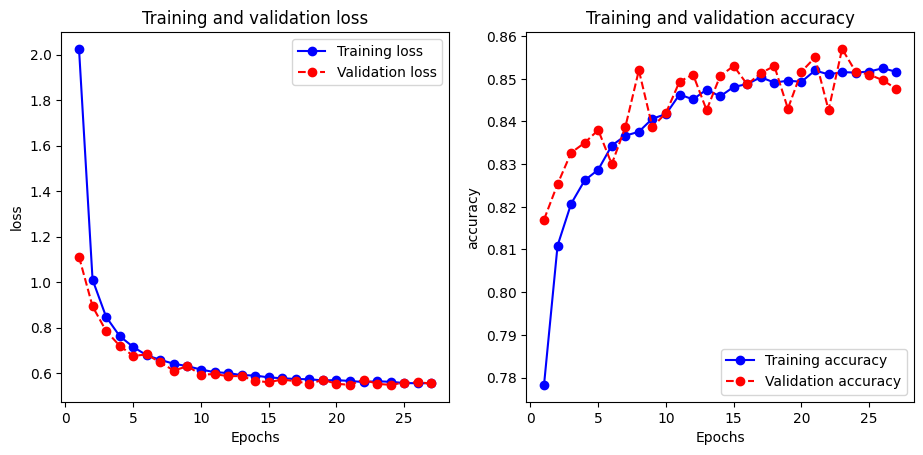

In [19]:
multiplot(history)

In [20]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.70      0.77      0.73      1000
       Dress       0.84      0.85      0.85      1000
        Coat       0.70      0.80      0.75      1000
      Sandal       0.95      0.91      0.93      1000
       Shirt       0.68      0.50      0.57      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.93      0.94      0.94      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



A pesar de que la regularización L1 sí evita el sobreentrenamiento, también se reduce la capacidad del modelo, obteniendo en torno a un **85% de accuracy**.

La regularización L1 promueve pesos 0, lo que funciona muy bien cuando los datos tienen representaciones dispersas. Sin embargo, Fashion-MNIST no es un problema con características dispersas, y la penalización de L1 introduce demasiada fuerza de regularización, lo que reduce la capacidad del modelo.

- **Regularización L2 (Ridge)**

$$
loss = error(y, \hat y) + \lambda \sum_{i=0}^N w_i^2
$$

In [21]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(128, kernel_regularizer=regularizers.l2(1e-3), activation="relu"),
        layers.Dense(64, kernel_regularizer=regularizers.l2(1e-3), activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

history = fit(model)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8054 - loss: 0.7784 - val_accuracy: 0.8390 - val_loss: 0.6334
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - loss: 0.5784 - val_accuracy: 0.8563 - val_loss: 0.5380
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8619 - loss: 0.5185 - val_accuracy: 0.8633 - val_loss: 0.5008
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8683 - loss: 0.4825 - val_accuracy: 0.8720 - val_loss: 0.4797
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8726 - loss: 0.4611 - val_accuracy: 0.8737 - val_loss: 0.4502
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8738 - loss: 0.4471 - val_accuracy: 0.8723 - val_loss: 0.4377
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8768 - loss: 0.4360 - val_accuracy: 0.8803 - val_loss: 0.4302
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8787 - loss: 0.4244 - val_accuracy: 0.

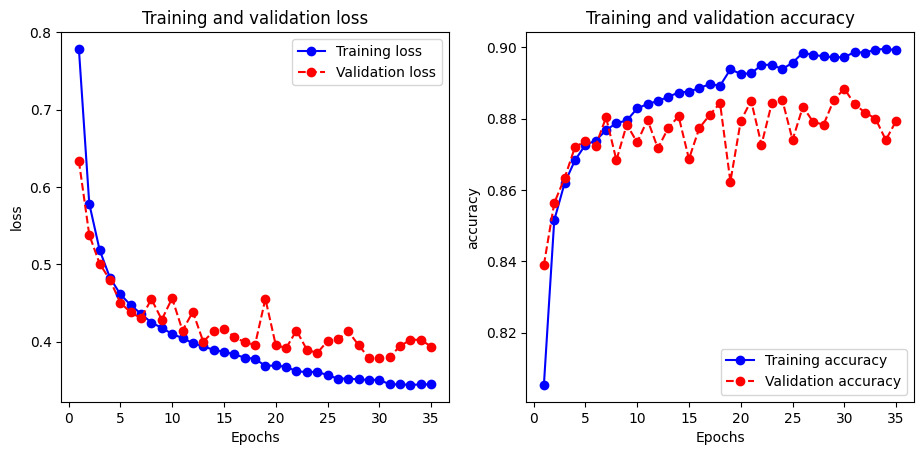

In [22]:
multiplot(history)

In [23]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.82      0.83      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.86      0.67      0.76      1000
       Dress       0.86      0.91      0.88      1000
        Coat       0.74      0.85      0.79      1000
      Sandal       0.95      0.96      0.96      1000
       Shirt       0.70      0.70      0.70      1000
     Sneaker       0.95      0.93      0.94      1000
         Bag       0.94      0.98      0.96      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



L2 penaliza los pesos grandes, empujándolos a valores pequeños, pero no a 0. Esto hace que la red sea más estable, haciendo que no dependa demasiado de conexiones concretas.

Vemos por lo tanto, que la mejor regulación para este caso en concreto es la regularización L2, puesto que produce resultados más estables.

#### Inicialización de pesos

In [33]:
initializer = initializers.GlorotNormal()

model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(
            128,
            activation="relu",
            kernel_initializer=initializer,
        ),
        layers.Dense(
            64,
            activation="relu",
            kernel_initializer=initializer,
        ),
        layers.Dense(10, activation="softmax", kernel_initializer=initializer),
    ]
)

history = fit(model)

Epoch 1/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8105 - loss: 0.5464 - val_accuracy: 0.8527 - val_loss: 0.4043
Epoch 2/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8621 - loss: 0.3889 - val_accuracy: 0.8523 - val_loss: 0.3949
Epoch 3/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8735 - loss: 0.3515 - val_accuracy: 0.8720 - val_loss: 0.3485
Epoch 4/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8832 - loss: 0.3254 - val_accuracy: 0.8747 - val_loss: 0.3497
Epoch 5/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8870 - loss: 0.3078 - val_accuracy: 0.8740 - val_loss: 0.3454
Epoch 6/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8926 - loss: 0.2914 - val_accuracy: 0.8740 - val_loss: 0.3663
Epoch 7/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8955 - loss: 0.2801 - val_accuracy: 0.8780 - val_loss: 0.3282
Epoch 8/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9016 - loss: 0.2688 - val_accuracy: 0.

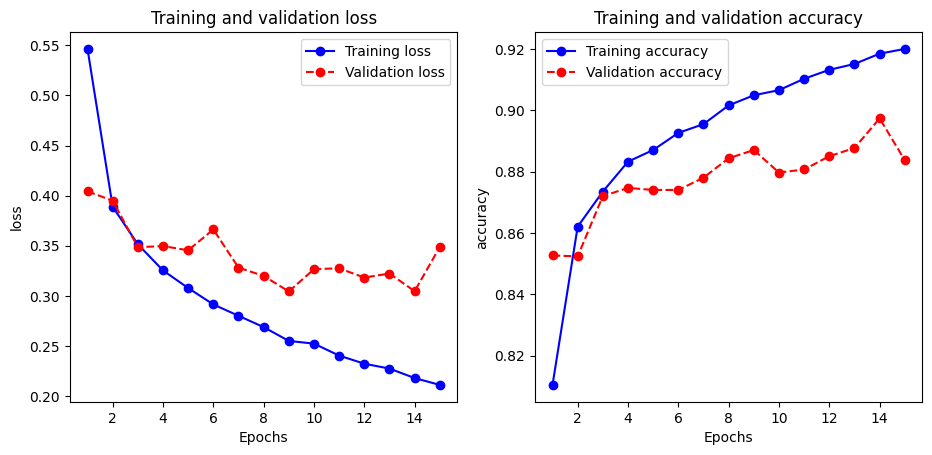

In [34]:
multiplot(history)

In [35]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.86      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.80      0.77      0.78      1000
       Dress       0.86      0.91      0.88      1000
        Coat       0.75      0.84      0.80      1000
      Sandal       0.98      0.95      0.96      1000
       Shirt       0.75      0.62      0.68      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.98      0.95      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Tras haber probado diferentes inicializadores, concluimos que no se producen diferencias significativas en cuanto a los resultados, excepto para los inicializacores `Zeros` y `Ones`, que producen resultados nefastos.

## 4.Resultados

Tras haber probado las diferentes técnicas de regulación vistas en la sección anterior, nos disponemos a aplicar varias de ellas de manera simultánea para obtener un resultado mejor que el de aplicarlas de manera individual.

En este caso, y tras haber probado diferentes opciones, nos quedamos con:

- **Dropout del 30%**, puesto que es la técnica que hemos probado con la que mejor evitamos el sobreentrenamiento.
- **Bach normalization**, ya que si únicamente utililizamos dropout, no conseguimos reducir tanto el sobreentrenamiento.

No incluimos **regularización L1** ni **L2** porque empeoran los resultados (excepto si el coeficiente es muy bajo, en cuyo caso no hace nada).

También hemos dejado fuera la **inicialización de pesos**, ya que, para este problema en concreto y con este tipo de red, no produce ninguna diferencia.

In [27]:
model = Sequential(
    [
        layers.Input(shape=(784,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax"),
    ]
)

summary = fit(model, patience=8)

Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7637 - loss: 0.6976 - val_accuracy: 0.8427 - val_loss: 0.4341
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8240 - loss: 0.4951 - val_accuracy: 0.8603 - val_loss: 0.3701
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8402 - loss: 0.4501 - val_accuracy: 0.8567 - val_loss: 0.3806
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8471 - loss: 0.4301 - val_accuracy: 0.8643 - val_loss: 0.3524
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8510 - loss: 0.4163 - val_accuracy: 0.8713 - val_loss: 0.3440
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8507 - loss: 0.4121 - val_accuracy: 0.8657 - val_loss: 0.3496
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8580 - loss: 0.4003 - val_accuracy: 0.8657 - val_loss: 0.3613
Epoch 8/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8607 - loss: 0.3924 - val_accuracy: 0.

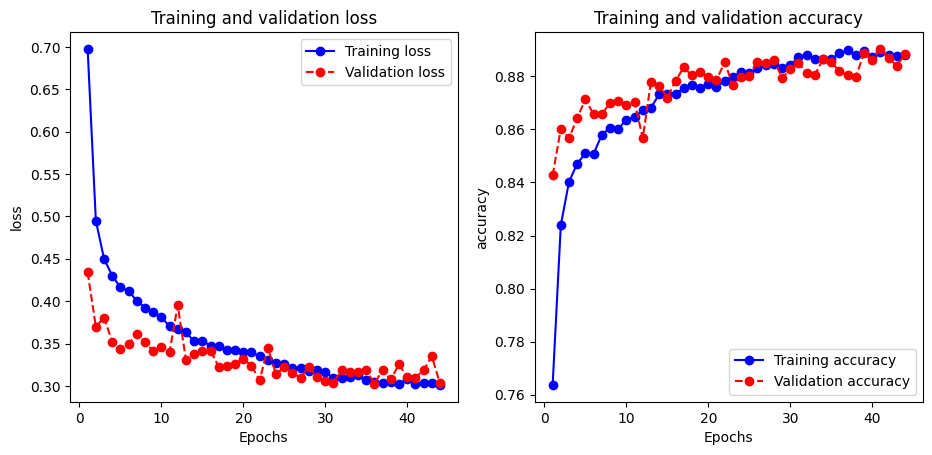

In [28]:
multiplot(summary)

In [29]:
evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.72      0.77      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.96      0.97      0.97      1000
       Shirt       0.67      0.70      0.68      1000
     Sneaker       0.94      0.93      0.94      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## 5. Conclusiones

Tras haber analizado los resultados para los diferentes modelos desarrollados, vemos que, en aquellas secciones en las que somos capaces de evitar el sobreentrenamiento, no somos capaces de obtener, en ninguno de los casos, una red que se comporte mejor para el conjunto de test. En el mejor de los casos nos quedamos en torno al **88% de accuracy**, lo cual es señal de un límite en la capacidad predictiva de las arquitecturas empleadas.

Podemos observar también que el modelo obtiene peores resultados en:

- **Camisas** (shirt).
- **Chaquetas** (coat).
- **Jerseis** (pullover).

Esto no es de extrañar puesto que son prendas de ropa bastante similares entre sí, lo que reduce la separabilidad entre clases y dificulta su correcta clasificación.

Los resultados indican que probablemente estemos ante una limitación propia de la arquitectura utilizada. Al aplanar las imágenes para alimentar una red neuronal, se pierde la información espacial inherente a la estructura de la imagen (relaciones entre píxeles, textura y forma).

Esta pérdida de información restringe la capacidad del modelo para aprender patrones visuales complejos.

Una alternativa para superar esta limitación sería emplear redes neuronales convolucionales (CNN). Estas arquitecturas explotan la relación espacial entre píxeles mediante filtros convolucionales, lo que tiende a producir mejores resultados en tareas de visión por computador como esta.

---

**Nota sobre las métricas utilizadas**
        
En cuanto a las métricas empleadas, utilizamos el **accuracy** como medida principal de rendimiento. Otras métricas como *precision* o *recall* suelen ser relevantes en problemas donde existe una clase positiva con mayor importancia que la negativa.

Dado que este no es el caso, y que además el dataset está balanceado, tampoco resulta muy relevante emplear medidas como el *f1-score*, que se utilzan habitualmente cuando existe un fuerte desbalanceo entre clases.

Por lo tanto el accuracy, para este problema concreto, es una métrica suficiente y representativa del rendimiento del modelo.